In [7]:
import torch
import torch.nn as nn

import torch_geometric
from torch_geometric.nn import GCNConv, SoftmaxAggregation
from torch_geometric.datasets import QM9
import torch_geometric.nn as gnn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LinearRegression

import numpy as np
import matplotlib.pyplot as plt

metrics = [mean_squared_error, mean_absolute_error, r2_score]
import copy
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
qm9_index = {0: 'Dipole moment',
1: 'Isotropic polarizability',
2: 'Highest occupied molecular orbital energy',
3: 'Lowest unoccupied molecular orbital energy',
4: 'Gap between previous 2',
5: 'Electronic spatial extent',
6: 'Zero point vibrational energy',
7: 'Internal energy at 0K',
8: 'Internal energy at 298.15K',
9: 'Enthalpy at 298.15K',
10: 'Free energy at 298.15K',
11: 'Heat capavity at 298.15K',
12: 'Atomization energy at 0K',
13: 'Atomization energy at 298.15K',
14: 'Atomization enthalpy at 298.15K',
15: 'Atomization free energy at 298.15K',
16: 'Rotational constant A',
17: 'Rotational constant B',
18: 'Rotational constant C',}

In [9]:
parameters = {}
parameters['n_epochs'] = 50
parameters['learning_rate'] = 3e-4
parameters['batch_size'] = 256

In [10]:
whole_dataset = QM9(root = 'data/')
n = whole_dataset.len()
tr_n = 0.5  # Number of QM9 to use as training data

all_inds = range(n)
tr_inds, val_inds = train_test_split(all_inds, train_size = tr_n)
train_set = torch.utils.data.Subset(whole_dataset, tr_inds)
val_set = torch.utils.data.Subset(whole_dataset, val_inds)

train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = parameters['batch_size'],
                                                shuffle = True, num_workers = 2,)

big_train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = 4096*2,
                                                shuffle = True, num_workers = 2,)

val_loader = torch_geometric.loader.DataLoader(val_set, batch_size=4096*2, # I am using this to get a random subset of the val set
                                            shuffle=True, num_workers=2,)

In [11]:
class Supervised_GCN_Equivalent(torch.nn.Module):
    def __init__(self, c_dim):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        self.c_dim = c_dim
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.conv1.aggr = SoftmaxAggregation(learn=True)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.conv2.aggr = SoftmaxAggregation(learn=True)
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Projection to embedding
        self.fc2 = nn.Linear(self.rep_dim, self.c_dim) # Linear to rep?
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        x_rep = self.mpool1(x, binds)
        yhat = self.fc2(x_rep)
        
        return yhat


[[], [], []]
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8072]) torch.Size([8072])
Returning validation scores mat torch.Size([3, 8])
train embeddings torch.Size([8192, 128])
batch embeding: torch.Size([8192, 128])
Returning transfer scores torch.Size([19, 3])
Epoch loss: 1.61
Validation scores: tensor([[ 1.6479,  1.6877,  1.5888,  1.6415,  1.6159,  1.6365,  1.6271,  1.7775],
        [ 0.9573,  0.9669,  0.9490,  0.9512,  0.9564,  0.9625,  0.9562,  0.9658],
        [-1.6658, -1.7752, -1.6415, -1.7550, -1.6497, -1.7299, -1.7907, -1.8003]])
Transfer scores: tensor([[ 2.2665e+00,  1.1327e+00, -1.7741e+00],
    

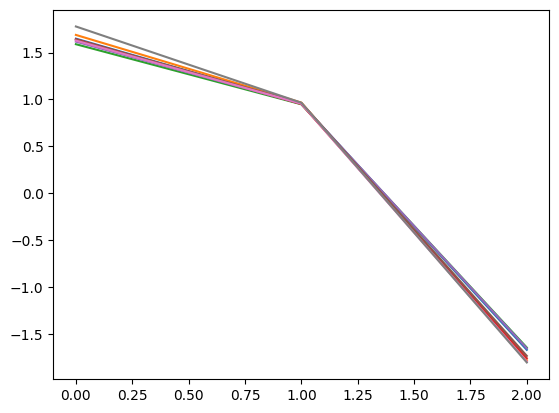

train embeddings torch.Size([8192, 128])
batch embeding: torch.Size([8192, 128])
Returning transfer scores torch.Size([19, 3])
[[], [], []]
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8072]) torch.Size([8072])
Returning validation scores mat torch.Size([3, 8])
train embeddings torch.Size([8192, 128])
batch embeding: torch.Size([8192, 128])
Returning transfer scores torch.Size([19, 3])
Epoch loss: 1.62
Validation scores: tensor([[ 1.7083,  1.7241,  1.6081,  1.6410,  1.7245,  1.5897,  1.6170,  1.7225],
        [ 0.9696,  0.9738,  0.9575,  0.9547,  0.9625,  0.9621,  0.9560,  0.9646],
        [-1.7226, -1.7705,

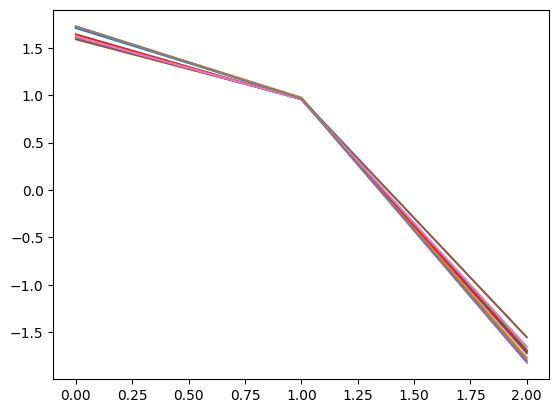

train embeddings torch.Size([8192, 128])
batch embeding: torch.Size([8192, 128])
Returning transfer scores torch.Size([19, 3])
[[], [], []]
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8072]) torch.Size([8072])
Returning validation scores mat torch.Size([3, 8])
train embeddings torch.Size([8192, 128])
batch embeding: torch.Size([8192, 128])
Returning transfer scores torch.Size([19, 3])
Epoch loss: 1.62
Validation scores: tensor([[ 1.6443,  1.6444,  1.5273,  1.6892,  1.6449,  1.6047,  1.7426,  1.7998],
        [ 0.9610,  0.9542,  0.9443,  0.9530,  0.9627,  0.9460,  0.9666,  0.9707],
        [-1.8526, -1.8414,

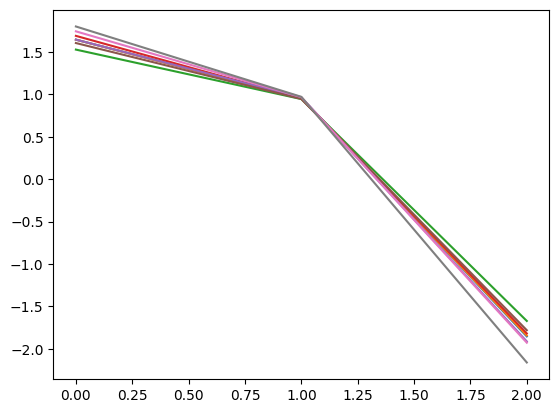

train embeddings torch.Size([8192, 128])
batch embeding: torch.Size([8192, 128])
Returning transfer scores torch.Size([19, 3])


In [12]:
def test_supervised(model, dataloader, parameters):
    # Test the supervised model on a set
    task_index = parameters['task']
    
    scoremat = [ [] for _ in range(len(metrics)) ]
    print(scoremat)
    
    for batchi, batch in enumerate(val_loader):
        
        batch_inds = batch.batch.to(device)
        batch.x = batch.x.float()#.to(device)

        # Augment batch?
        #batch = aug(batch.x, batch.edge_index, batch.edge_attr)
        
        with torch.no_grad():
            yhat = model([batch.x, batch.edge_index, batch.edge_attr], batch_inds).cpu().squeeze()
        
        print('going into metrics', yhat.shape, batch.y[:,task_index].shape)
        # Metrics
        for meti, metric in enumerate(metrics):
            met = metric(yhat, batch.y[:,task_index])
            scoremat[meti].append(met)
        
    print('Returning validation scores mat', torch.FloatTensor(scoremat).shape)
    return torch.FloatTensor(scoremat)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
def transfer_supervised(model, val_loader, parameters):
    # Transfer a model trained under the supervised paradigm

    
    model_copy = copy.deepcopy(model)
    
    model_copy.fc2 = Identity()
    
    # Need to get training set embeddings:
    train_batch = next(iter(big_train_loader))
    with torch.no_grad():
        tr_emb = model_copy([train_batch.x.float().to(device), train_batch.edge_index, train_batch.edge_attr], train_batch.batch.to(device)).cpu()
        print('train embeddings', tr_emb.shape)
    
    val_batch = next(iter(val_loader))

    batch_inds = val_batch.batch.to(device)
    val_batch.x = val_batch.x.float()#.to(device)

    # Augment batch?
    #batch = aug(batch.x, batch.edge_index, batch.edge_attr)

    with torch.no_grad():
        val_emb = model_copy([val_batch.x, val_batch.edge_index, val_batch.edge_attr], batch_inds).cpu()
        print('batch embeding:', val_emb.shape)

    scoremat = torch.zeros((len(qm9_index.keys()), len(metrics)))
    for task in qm9_index.keys():
        linear_classifier = LinearRegression().fit(tr_emb, train_batch.y[:,task])
        yhat = linear_classifier.predict(val_emb)
        for meti, metric in enumerate(metrics):
            met = metric(yhat, val_batch.y[:,task])
            scoremat[task, meti] = met.astype(np.float64)
            
    print('Returning transfer scores', scoremat.shape)
    return scoremat

    
def train_supervised(parameters):
    
    # Get target types from parameters - one task or 19?
    task_index = parameters['task'] # An index for which task the model is trained on - or 'all'
    
    if task_index == 'all':
        #task_index = [0:]
        pass
    else:
        #task_index = [task:task+1]
        pass
    
    device = 'cuda'
    model = Supervised_GCN_Equivalent(c_dim = 1).to(device)
    
    mse_loss = torch.nn.MSELoss()
    n_epochs = parameters['n_epochs']
    
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=5e-4)

    tr_losses = []
    val_losses = []

    for epoch in range(0,n_epochs+1):
        epoch_losses = []
        for batch in train_loader:
            optimizer.zero_grad()

            batch_inds = batch.batch.to(device)
            batch.x = batch.x.float()#.to(device)

            # Augment batch?
            #batch = aug(batch.x, batch.edge_index, batch.edge_attr)

            # Embed each batch (ignoring representations)
            yhat = model([batch.x, batch.edge_index, batch.edge_attr], batch_inds).squeeze()

            loss = mse_loss(yhat, batch.y[:,task_index].to(device))
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.data.item())
                        
        # test the model
        if epoch == n_epochs:
            supervised_loss = test_supervised(model, val_loader, parameters)
            transfer_scores = transfer_supervised(model, val_loader, parameters)
        
            print('Epoch loss:', round(sum(epoch_losses) / len(epoch_losses), 2))
            print('Validation scores:', supervised_loss)
            print('Transfer scores:', transfer_scores)
            
    return model, supervised_loss, transfer_scores


n_trials = 3
for i in range(n_trials):
    parameters['task'] = 0
    model, loss, scores = train_supervised(parameters)
    plt.plot(loss)
    plt.show()
    scores = transfer_supervised(model, val_loader, parameters)
    torch.save(scores, f'heatmap_results/supervised_{i}.pt')


In [13]:
for met, row in zip(metrics, scores.T):
    #print(met, row)
    for i, item in enumerate(row):
        print(met, qm9_index[i], item)
        
torch.save(scores, 'transfer_score_demo.pt')

<function mean_squared_error at 0x0000018E4CA4FC70> Dipole moment tensor(1361.8596)
<function mean_squared_error at 0x0000018E4CA4FC70> Isotropic polarizability tensor(155.3465)
<function mean_squared_error at 0x0000018E4CA4FC70> Highest occupied molecular orbital energy tensor(443.6233)
<function mean_squared_error at 0x0000018E4CA4FC70> Lowest unoccupied molecular orbital energy tensor(300.7607)
<function mean_squared_error at 0x0000018E4CA4FC70> Gap between previous 2 tensor(14.9474)
<function mean_squared_error at 0x0000018E4CA4FC70> Electronic spatial extent tensor(96537.4844)
<function mean_squared_error at 0x0000018E4CA4FC70> Zero point vibrational energy tensor(4.6094)
<function mean_squared_error at 0x0000018E4CA4FC70> Internal energy at 0K tensor(1.3379e+09)
<function mean_squared_error at 0x0000018E4CA4FC70> Internal energy at 298.15K tensor(1.3378e+09)
<function mean_squared_error at 0x0000018E4CA4FC70> Enthalpy at 298.15K tensor(1.3379e+09)
<function mean_squared_error at 